# Configuración de librerías y tensorflow object detection

In [1]:
%cd
  
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib PyDrive

!pip install -q pycocotools

%cd ~/models/research
!protoc object_detection/protos/*.proto --python_out=.

/root
Selecting previously unselected package libprotobuf10:amd64.
(Reading database ... 26397 files and directories currently installed.)
Preparing to unpack .../libprotobuf10_3.0.0-9.1ubuntu1_amd64.deb ...
Unpacking libprotobuf10:amd64 (3.0.0-9.1ubuntu1) ...
Selecting previously unselected package libprotoc10:amd64.
Preparing to unpack .../libprotoc10_3.0.0-9.1ubuntu1_amd64.deb ...
Unpacking libprotoc10:amd64 (3.0.0-9.1ubuntu1) ...
Selecting previously unselected package protobuf-compiler.
Preparing to unpack .../protobuf-compiler_3.0.0-9.1ubuntu1_amd64.deb ...
Unpacking protobuf-compiler (3.0.0-9.1ubuntu1) ...
Setting up libprotobuf10:amd64 (3.0.0-9.1ubuntu1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Setting up libprotoc10:amd64 (3.0.0-9.1ubuntu1) ...
Setting up protobuf-compiler (3.0.0-9.1ubuntu1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
/root/models/research


Configuración de path

In [0]:
import os
os.environ['PYTHONPATH'] += ':/root/models/research/:/root/models/research/slim/'

#Montar Datos Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!pwd

/root/models/research


# Librerías


In [5]:

import numpy as np
import os
import tensorflow as tf

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
#Librerías de TENSORFLOW object detection
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

/root/models/research/object_detection/utils/visualization_utils.py:27: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "<decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 87, in catch_config_e

**Ubicación del modelo generado y el mapa de etiquetas**

In [0]:
#Modelo congelado, generado después del entrenamiento de las 32 especies
PATH_TO_CKPT = '/content/drive/My Drive/frozen_inference_graph.pb'

# Mapeo de las clases entero-texto
PATH_TO_LABELS = os.path.join('/content/drive/My Drive/EntrenamientoFinal/', 'label_map.pbtxt')

NUM_CLASSES = 32

**Cargar el modelo .pb**

In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

**Cargar el mapa de características**

In [0]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

**Leer imagen y obtener en un arreglo numpy**

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

IMAGE_SIZE = (12, 8)

In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:

      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:

        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
 
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')


      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

Para visualizar el nombre de la clase y el tipo de venenoso o comestible

In [0]:
def class_int_to_text(row_label):
    if row_label == 1:  
        return 'Amanitacaesarea COMESTIBLE'
    elif row_label==2:
        return 'Amanitamuscaria VENENOSA TIPO 1'
    if row_label == 3:  
        return 'Amanitabisporigera VENENOSO TIPO 1'
    elif row_label==4:
        return 'Amanitapantherina VENENOSO TIPO 2'
    if row_label == 5:  
        return 'Amanitaphalloides VENENOSO TIPO 1'
    elif row_label==6:
        return 'Boletusedulis COMESTIBLE'
    if row_label == 7:  
        return 'Gomphusfloccosus COMESTIBLE'
    elif row_label==8:
        return 'Gyromitrainfula VENENOSO 3'
    if row_label == 9:  
        return 'Gyromitrinaesculenta VENENOSO TIPO 2'
    elif row_label==10:
        return 'Laetiporussulphureus VENENOSO TIPO 3'
    if row_label == 11:  
        return 'Lycoperdonperlatum COMESTIBLE'
    elif row_label==12:
        return 'Russulaemetica VENENOSO TIPO 4'
        
    if row_label == 13:  
        return 'Lactariusindigo COMESTIBLE'
    elif row_label==14:
        return 'Cantharelluscibarius COMESTIBLE'
    if row_label == 15:  
        return 'Helvellacrispa COMESTIBLE'
    elif row_label==16:
        return 'Clavulina coralloides COMESTIBLE'
    if row_label == 17:  
        return 'Clavariadelphustruncatus COMESTIBLE'
    elif row_label==18:
        return 'Geastrumtriplex COMESTIBLE'
    if row_label == 19:  
        return 'Hypomyces lactifluorum COMESTIBLE'
    elif row_label==20:
        return 'Leotialubrica COMESTIBLE'
    if row_label == 21:  
        return 'Morchellaesculenta COMESTIBLE'
    elif row_label==22:
        return 'Sparassiscispa COMESTIBLE'
    if row_label == 23:  
        return 'Lactariustorminosus VENENOSO TIPO 4'
    elif row_label==24:
        return 'Pholiotasquarrosa VENENOSO TIPO 3'
    if row_label == 25:  
        return 'Lepiotacristata VENENOSO TIPO 1'
    elif row_label==26:
        return 'LepiotamagnisporaMurrill VENENOSO TIPO 1'
    if row_label == 27:  
        return 'Auriculariaauriculajudaes COMESTIBLE'
    elif row_label==28:
        return 'Helvellalacunosa COMESTIBLE'
    if row_label == 29:  
        return 'Agaricuscampestris COMESTIBLE'
    elif row_label==30:
        return 'Tricholomamagnivelare COMESTIBLE'
    if row_label == 31:  
        return 'Suillusgranilatus COMESTIBLE'
    elif row_label==32:
        return 'Russulabrevipes COMESTIBLE'
    
    else:
        print(row_label)

#Subir imagen

In [13]:
from google.colab import files
uploaded = files.upload() 



Saving Russulaemetica-94.jpg to Russulaemetica-94.jpg
{'Russulaemetica-94.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x02\x9a\x01\xf4\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\

# Ejecutar modelo

Russulaemetica VENENOSO TIPO 4
99.89824891090393


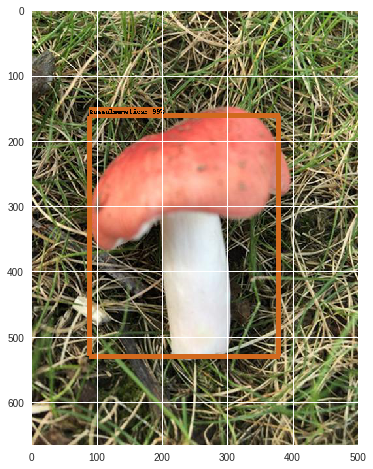

In [16]:
image = Image.open('Russulaemetica-94.jpg')

image_np = load_image_into_numpy_array(image)

image_np_expanded = np.expand_dims(image_np, axis=0)
output_dict = run_inference_for_single_image(image_np, detection_graph)


print(class_int_to_text(output_dict['detection_classes'][0]))
print(output_dict['detection_scores'][0]*100)
  
 
vis_util.visualize_boxes_and_labels_on_image_array(image_np, output_dict['detection_boxes'], output_dict['detection_classes'], output_dict['detection_scores'],category_index, instance_masks=output_dict.get('detection_masks'),use_normalized_coordinates=True,line_thickness=8)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)